<a href="https://colab.research.google.com/github/TensorTobio/Projects/blob/main/GDP_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from statsmodels.tsa.arima.model import ARIMA


In [40]:
df = pd.read_csv("world_gdp_data.csv", encoding="latin1")
df.head()




,country_name,indicator_name,1980,1981,1982,1983,1984,1985,1986,1987,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Afghanistan,Annual GDP growth (percent change),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,2.2,2.6,1.2,3.9,-2.4,-20.7,NaN,NaN,NaN
1,Albania,Annual GDP growth (percent change),2.7,5.7,2.9,1.1,2.0,-1.5,5.6,-0.8,...,2.2,3.3,3.8,4.0,2.1,-3.3,8.9,4.8,3.6,3.3
2,Algeria,Annual GDP growth (percent change),-5.4,3.0,6.4,5.4,5.6,5.6,-0.2,-0.7,...,3.7,3.2,1.4,1.2,1.0,-5.1,3.4,3.2,3.8,3.1
3,Andorra,Annual GDP growth (percent change),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.4,3.7,0.3,1.6,2.0,-11.2,8.3,8.8,2.1,1.5
4,Angola,Annual GDP growth (percent change),2.4,-4.4,0.0,4.2,6.0,3.5,2.9,4.1,...,0.9,-2.6,-0.2,-1.3,-0.7,-5.6,1.2,3.0,1.3,3.3


In [43]:
df = df[df["indicator_name"] == "Annual GDP growth (percent change)"]
year_cols = [col for col in df.columns if col.isdigit()]

df_long = df.melt(
    id_vars=["country_name"],
    value_vars=year_cols,
    var_name="year",
    value_name="gdp_growth"
)

df_long["year"] = pd.to_numeric(df_long["year"], errors="coerce")
df_long["gdp_growth"] = pd.to_numeric(df_long["gdp_growth"], errors="coerce")

df_long = df_long.dropna()
df_long["year"] = df_long["year"].astype(int)

df_long.head()



,country_name,year,gdp_growth
1,Albania,1980,2.7
2,Algeria,1980,-5.4
4,Angola,1980,2.4
5,Antigua and Barbuda,1980,8.2
6,Argentina,1980,0.7


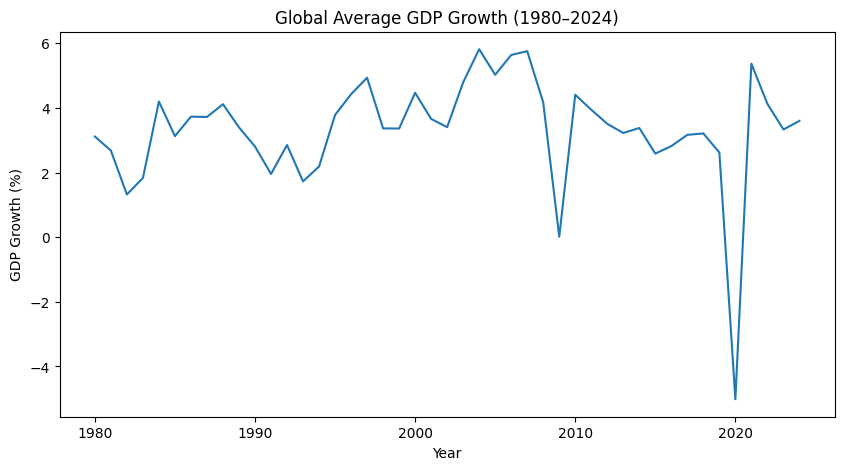

In [44]:
global_avg = df_long.groupby("year")["gdp_growth"].mean()

plt.figure(figsize=(10,5))
plt.plot(global_avg)
plt.title("Global Average GDP Growth (1980–2024)")
plt.xlabel("Year")
plt.ylabel("GDP Growth (%)")
plt.show()


In [45]:
features = df_long.groupby("country_name").apply(lambda x: pd.Series({
    "mean_growth": x["gdp_growth"].mean(),
    "volatility": x["gdp_growth"].std(),
    "neg_freq": (x["gdp_growth"] < 0).mean(),
    "growth_2009": x.loc[x["year"] == 2009, "gdp_growth"].mean(),
    "growth_2020": x.loc[x["year"] == 2020, "gdp_growth"].mean(),
    "recovery_2010_11": x.loc[x["year"].isin([2010,2011]), "gdp_growth"].mean(),
    "recovery_2021_22": x.loc[x["year"].isin([2021,2022]), "gdp_growth"].mean(),
})).dropna()

features.head()


,mean_growth,volatility,neg_freq,growth_2009,growth_2020,recovery_2010_11,recovery_2021_22
country_name,,,,,,,
Afghanistan,4.710526,8.338458,0.105263,20.6,-2.4,7.45,-20.70
Albania,2.906667,6.786229,0.177778,3.4,-3.3,3.10,6.85
Algeria,2.491111,2.752009,0.177778,1.6,-5.1,3.25,3.30
Andorra,1.700000,5.192972,0.250000,-5.3,-11.2,-1.00,8.55
Angola,4.793333,5.218777,0.155556,0.9,-5.6,4.20,2.10


In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=4, random_state=42)
features["cluster"] = kmeans.fit_predict(X_scaled)

features.head()


,mean_growth,volatility,neg_freq,growth_2009,growth_2020,recovery_2010_11,recovery_2021_22,cluster
country_name,,,,,,,,
Afghanistan,4.710526,8.338458,0.105263,20.6,-2.4,7.45,-20.70,2
Albania,2.906667,6.786229,0.177778,3.4,-3.3,3.10,6.85,2
Algeria,2.491111,2.752009,0.177778,1.6,-5.1,3.25,3.30,1
Andorra,1.700000,5.192972,0.250000,-5.3,-11.2,-1.00,8.55,1
Angola,4.793333,5.218777,0.155556,0.9,-5.6,4.20,2.10,2


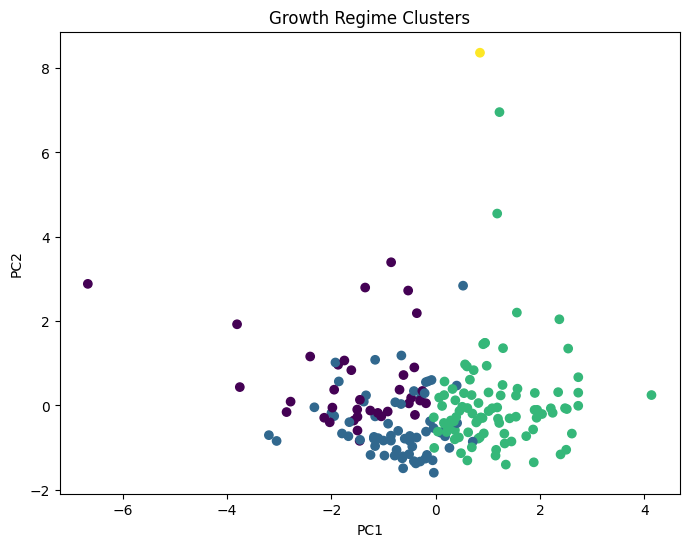

In [47]:
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

features["pc1"] = coords[:,0]
features["pc2"] = coords[:,1]

plt.figure(figsize=(8,6))
plt.scatter(features["pc1"], features["pc2"], c=features["cluster"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Growth Regime Clusters")
plt.show()


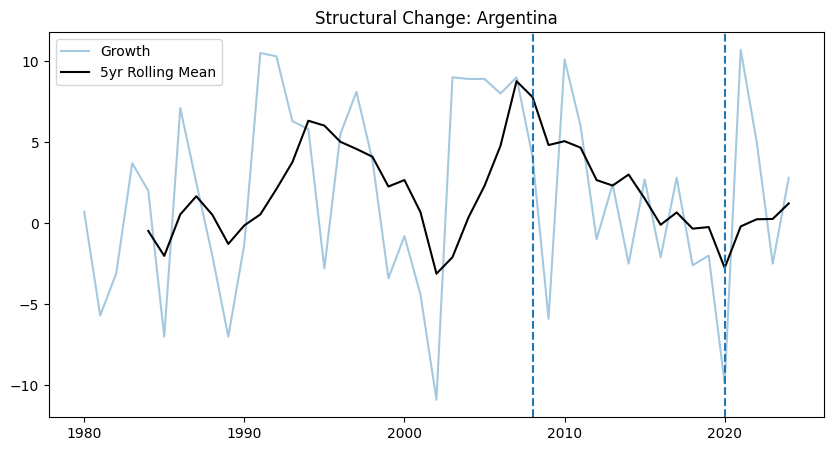

In [48]:
country = "Argentina"

c = df_long[df_long["country_name"] == country].sort_values("year")
c["rolling"] = c["gdp_growth"].rolling(5).mean()

plt.figure(figsize=(10,5))
plt.plot(c["year"], c["gdp_growth"], alpha=0.4, label="Growth")
plt.plot(c["year"], c["rolling"], color="black", label="5yr Rolling Mean")
plt.axvline(2008, linestyle="--")
plt.axvline(2020, linestyle="--")
plt.legend()
plt.title(f"Structural Change: {country}")
plt.show()


In [49]:
ts = df_long[df_long["country_name"] == "Argentina"].set_index("year")["gdp_growth"]

model = ARIMA(ts, order=(2,0,2))
fit = model.fit()

forecast = fit.get_forecast(steps=5)
forecast_df = forecast.summary_frame()
forecast_df


gdp_growth,mean,mean_se,mean_ci_lower,mean_ci_upper
45,3.669347,5.424346,-6.962177,14.300870
46,3.203208,5.455890,-7.490140,13.896557
47,2.952518,5.572799,-7.969966,13.875003
48,2.766853,5.658290,-8.323191,13.856898
49,2.624514,5.709209,-8.565330,13.814359


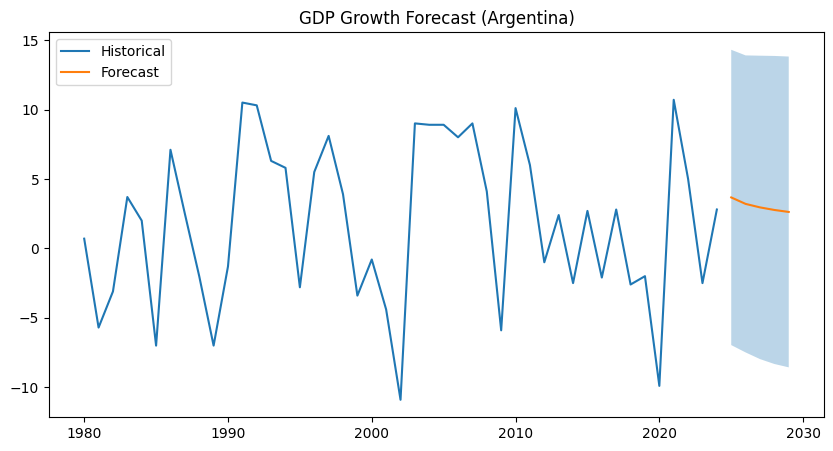

In [50]:
future_years = range(ts.index.max()+1, ts.index.max()+6)

plt.figure(figsize=(10,5))
plt.plot(ts.index, ts, label="Historical")
plt.plot(future_years, forecast_df["mean"], label="Forecast")
plt.fill_between(future_years,
                 forecast_df["mean_ci_lower"],
                 forecast_df["mean_ci_upper"], alpha=0.3)
plt.legend()
plt.title("GDP Growth Forecast (Argentina)")
plt.show()


In [51]:
pre = df_long[df_long["year"] < 2020].groupby("country_name")["gdp_growth"].mean()
post = df_long[df_long["year"] >= 2020].groupby("country_name")["gdp_growth"].mean()

comparison = pd.DataFrame({
    "pre_covid": pre,
    "post_covid": post
})

comparison["difference"] = comparison["post_covid"] - comparison["pre_covid"]
comparison.head()


,pre_covid,post_covid,difference
country_name,,,
Afghanistan,6.623529,-11.55,-18.173529
Albania,2.837500,3.46,0.622500
Algeria,2.592500,1.68,-0.912500
Andorra,1.647368,1.90,0.252632
Angola,5.312500,0.64,-4.672500


In [52]:
features.to_csv("growth_clusters.csv")
comparison.to_csv("pre_post_covid_comparison.csv")
